<a href="https://colab.research.google.com/github/mmsaban/CS4240_group92/blob/main/code_mutation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision
import random

In [ ]:
# Data-Set Loader
tar0 = torch.load('tar_0.pt')
tar1 = torch.load('tar_1.pt')
tar2 = torch.load('tar_2.pt')
x_in = torch.load('x_in012.pt')
x_100_in =  x_in[100,:,:,:]
# torch.save(x_100_in, 'x_100_in.pt')
# x_100_in = torch.load('x_100_in.pt')
# y = torch.load('y_0_approx.pt')
# y_binary = torch.load('y_binary.pt')
# y_100_binary = y_binary[100,:,:,:]
# torch.save(y_100_binary, 'y_100_binary.pt')

FileNotFoundError: ignored

In [ ]:
y_1_binary = y_binary[1,:,:,:]
x_1_in =  x_in[1,:,:,:]

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
print(device)

cuda:0


In [ ]:
def tripple_conv(in_chan, out_chan):
    conv =nn.Sequential(
        nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True),
        nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True),
        nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True)
    )
    return conv

def double_conv_sigmoid(in_chan, out_chan):
    conv =nn.Sequential(
        nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True),
        nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
        nn.Sigmoid()
    )
    return conv

def double_conv_tanh(in_chan, out_chan):
    conv =nn.Sequential(
        nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
        nn.ELU(inplace=True),
        nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
        nn.Tanh()
    )
    return conv

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = tripple_conv(1, 48)
        self.down_conv_2 = tripple_conv(48, 96)
        self.down_conv_3 = tripple_conv(96, 192)

        self.up_trans_01 = nn.ConvTranspose2d(
            in_channels=192,
            out_channels=96,
            kernel_size=2,
            stride=2)
        
        self.up_conv_01 = tripple_conv(192, 96)
        
        self.up_trans_02= nn.ConvTranspose2d(
            in_channels=96,
            out_channels=48,
            kernel_size=2,
            stride=2)        
        
        self.up_conv_02 = tripple_conv(96, 48)
        
        #2nd temporal context module
    
        self.down_conv_11 = tripple_conv(144, 48)
        self.down_conv_12 = tripple_conv(48, 96)
        self.down_conv_13 = tripple_conv(96, 192)
        
        self.up_trans_11 = nn.ConvTranspose2d(
            in_channels=192,
            out_channels=96,
            kernel_size=2,
            stride=2)
        self.up_conv_11 = tripple_conv(192, 96)
        
        self.up_trans_12= nn.ConvTranspose2d(
            in_channels=96,
            out_channels=48,
            kernel_size=2,
            stride=2)         
        
        self.up_conv_12 = tripple_conv(96, 48)   
        
        #tripple head output 


        self.out_coor_brightness =  double_conv_sigmoid(48, 1)    
     

    def forward(self, image):
        x01 = self.down_conv_1(image)
        x02 =  self.max_pool_2x2(x01)
#        print('1st UNet down sampling stage 1 dimension', x02.size())
        x03 = self.down_conv_2(x02)
        x04 =  self.max_pool_2x2(x03) 
#        print('1st UNet down sampling stage 2 dimension', x04.size())
        x05 = self.down_conv_3(x04)
#        print('1st UNet transfer dimension', x05.size())

        #decoder
        x11 = self.up_trans_01(x05)
        x12= self.up_conv_01(torch.cat([x11, x03], 1))
#        print('1st UNet up sampling stage 1 dimension', x12.size())
        x13 = self.up_trans_02(x12)
        x14 = self.up_conv_02(torch.cat([x13, x01], 1))
#        print('1st UNet up sampling stage 2 dimension', x14.size())
#        print('x14', x14.size())

        return x14

    def temporal_context(self, image_t_min_1, image_t, image_t_plus_1):
        t_min_1 = self.forward(image_t_min_1)
        t = self.forward(image_t)
        t_plus_1 = self.forward(image_t_plus_1)
        output = torch.cat((t_min_1, t, t_plus_1), 1)
        return output

    def forward2(self, image_t_min_1, image_t, image_t_plus_1):
        image1 = self.temporal_context(image_t_min_1, image_t, image_t_plus_1)
        x21 = self.down_conv_11(image1) 
        x22 =  self.max_pool_2x2(x21) 
#        print('2nd UNet down sampling stage 1 dimension', x22.size())
        x23 = self.down_conv_12(x22)    
        x24 =  self.max_pool_2x2(x23) 
#        print('2nd UNet down sampling stage 2 dimension', x24.size())
        x25 = self.down_conv_13(x24)
#        print('2nd UNet transfer dimension', x25.size())
        
        #decoder
        x31 = self.up_trans_11(x25)
        x32= self.up_conv_11(torch.cat([x31, x23], 1))
#        print('2nd UNet up sampling stage 1 dimension', x32.size())
        x33 = self.up_trans_12(x32)
        x34 = self.up_conv_12(torch.cat([x33, x21], 1))                
#        print('2nd UNet up sampling stage 2 dimension', x34.size())

        return x34   

    def tripple_head(self, image_t_min_1, image_t, image_t_plus_1):
        head_split= self.forward2(image_t_min_1, image_t, image_t_plus_1)
#         print(head_split.size())

        out_coordinates_brightness = self.out_coor_brightness(head_split)

        

#        print('size of out_coordinates_brightness = ', out_coordinates_brightness.size())

        
        return out_coordinates_brightness
    

In [ ]:
if __name__ == "__main__":
    image_0 = torch.rand((1, 1, 40, 40))
    image_1 = torch.rand((1, 1, 40, 40))
    image_2 = torch.rand((1, 1, 40, 40))
    
    model_bolean = UNet().to(device)
    y_pred = model_bolean.tripple_head(image_0.to(device), image_1.to(device), image_2.to(device))

In [ ]:
# Only run when not having the y_0_approx or y_binary Data-Set
length = len(tar0)
y = torch.zeros(length, 2, 40, 40)
y_binary = torch.zeros(length, 1, 40, 40)
for j in range(length): 
    for i in range(250):
        y[j, 0, round(float(tar0[j,i,2])) , round(float(tar0[j,i,1])) ] = float(tar0[j,i,0])
        y_binary[j, 0, round(float(tar0[j,i,2])) , round(float(tar0[j,i,1])) ] = 255
        y[j, 1, round(float(tar0[j,i,2])) , round(float(tar0[j,i,1])) ] = float(tar0[j,i,3])  
torch.save(y_binary, 'y_binary.pt')        
torch.save(y, 'y_0_approx.pt') #y[i,j,k,l] i: #trainin instance, j=0: brightness, j=1: z-axis, k: x-axis, l: y-axis,

NameError: ignored

NameError: ignored

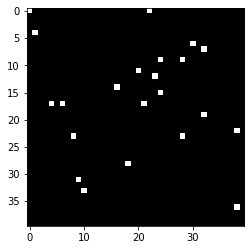

In [ ]:
idx = 1
plt.imshow(y_binary[idx,0,:,:], cmap='gray')
plt.scatter( tar0[idx,:,1], tar0[idx,:,2], s=300*tar0[idx,:,0], c='red', alpha=0.4)
plt.show()

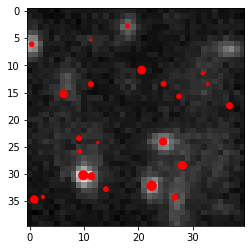

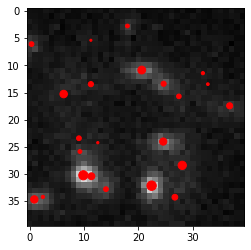

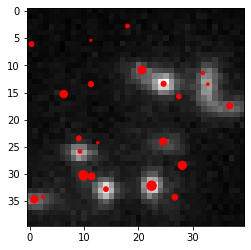

In [ ]:
idx = 11
plt.imshow(x_in[idx,0,:,:], cmap='gray')
plt.scatter(tar0[idx,:,2], tar0[idx,:,1], s=300*tar0[idx,:,0], c='red')
plt.show()

plt.imshow(x_in[idx,1,:,:], cmap='gray')
plt.scatter(tar0[idx,:,2], tar0[idx,:,1], s=300*tar0[idx,:,0], c='red')
plt.show()

plt.imshow(x_in[idx,2,:,:], cmap='gray')
plt.scatter(tar0[idx,:,2], tar0[idx,:,1], s=300*tar0[idx,:,0], c='red')
plt.show()

In [ ]:
torch.max(x_in[:,:,:,:])

tensor(11.2621)

In [ ]:
########RESET PARAM#######
# for layer in model_bolean.children():
#    if hasattr(layer, 'reset_parameters'):
#        layer.reset_parameters()
##########################
epoch_number = 0
loss = nn.BCELoss()
optimizer = torch.optim.AdamW(model_bolean.parameters(), lr=0.0006, weight_decay=0.1)
for epoch in range(100):
    epoch_number = epoch_number+1 
    print('Epoch #', epoch_number)
    i = 0
    r = list(range(len(y_binary)))
    random.shuffle(r)
    for idx in r:
        
        i = i + 1
        if i == 500:
            print('traininginstance #', i)
            # print(s)
        if i%10 ==0:
            print('traininginstance #', i)
            # print(s)
        
        image_0 = torch.zeros((1, 1, 40, 40))
        image_1 = torch.zeros((1, 1, 40, 40))
        image_2 = torch.zeros((1, 1, 40, 40))

        image_0[0,0]=   x_in[idx,0,:,:]   
        image_1[0,0]=   x_in[idx,1,:,:]
        image_2[0,0]=   x_in[idx,2,:,:]

        optimizer.zero_grad()
        model_bolean = UNet().to(device)
        y_pred  = model_bolean.tripple_head(image_0.to(device), image_1.to(device), image_2.to(device))
        y_pred = y_pred[0].to(device)
        y_pred = y_pred[0].to(device) #nodig om het jusite formaat van [40, 40] te realiseren 
        
        criterion = loss(y_pred, y_binary[idx,0,:,:].to(device)).to(device)   #y_pred.size() = [40, 40] , y_binary[idx,0,:,:].size = [40,40]
        criterion.backward()
        optimizer.step()
        # s = torch.sum(model_bolean.up_conv_12.weight.data)
    





  

Epoch # 1


AttributeError: ignored

100


In [ ]:

net = UNet()
print(net)

UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ELU(alpha=1.0, inplace=True)
    (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ELU(alpha=1.0, inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ELU(alpha=1.0, inplace=True)
    (2): Conv2d

In [ ]:
########RESET PARAM#######
# for layer in model.children():
#    if hasattr(layer, 'reset_parameters'):
#        layer.reset_parameters()

In [ ]:
idx = 1
if __name__ == "__main__":
    image_0 = torch.rand((1, 1, 40, 40))
    image_1 = torch.rand((1, 1, 40, 40))
    image_2 = torch.rand((1, 1, 40, 40))

    image_0[0,0]=   x_in[idx,0,:,:]   
    image_1[0,0]=   x_in[idx,1,:,:]
    image_2[0,0]=   x_in[idx,2,:,:]
    
    
    y_pred = model_bolean.tripple_head(image_0.to(device), image_1.to(device), image_2.to(device))

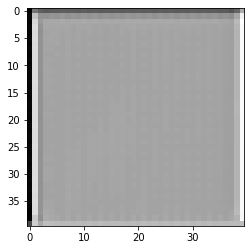

In [ ]:
y_pred_np = y_pred.cpu().detach().numpy()
plt.imshow(y_pred_np[0,0,:,:], cmap='gray')
# plt.scatter(tar0[idx,:,2], tar0[idx,:,1], s=300*tar0[idx,:,0], c='red', alpha=0.1)
plt.show()

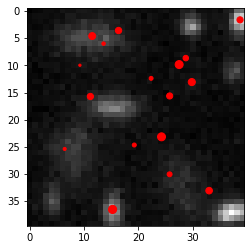

In [ ]:

plt.imshow(x_in[idx,2,:,:], cmap='gray')
plt.scatter(tar0[idx,:,2], tar0[idx,:,1], s=300*tar0[idx,:,0], c='red')
plt.show()   

In [ ]:
print(y_pred_np)

[[[[0.5075613  0.5080843  0.50848436 ... 0.508834   0.5098525
    0.5106619 ]
   [0.5046848  0.504403   0.5048233  ... 0.50565517 0.50796384
    0.5101184 ]
   [0.5041604  0.5033722  0.5038501  ... 0.5041182  0.5075084
    0.510019  ]
   ...
   [0.5037332  0.5026437  0.5028648  ... 0.5030404  0.50648713
    0.50953245]
   [0.5039799  0.5022465  0.5022488  ... 0.5024572  0.50594616
    0.50912094]
   [0.5052697  0.5028019  0.5021135  ... 0.5020529  0.5046455
    0.5076763 ]]]]
